In [0]:
#!pip install tensorflow==1.12.0
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import confusion_matrix

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("/data/MNIST/", one_hot=True)

Extracting /data/MNIST/train-images-idx3-ubyte.gz
Extracting /data/MNIST/train-labels-idx1-ubyte.gz
Extracting /data/MNIST/t10k-images-idx3-ubyte.gz
Extracting /data/MNIST/t10k-labels-idx1-ubyte.gz


In [0]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_classes = 10

In [0]:
test_images = data.test.images
data.train.cls = np.array([label.argmax() for label in data.train.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

In [7]:
print(data.train.cls.shape)
print(data.test.cls.shape)

(55000,)
(10000,)


In [0]:
#hyperparameters
hidden_layers = 5
batch_size = 128
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
iterations = 300000
lambda_reg = 0.01

In [0]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
decrease = math.floor((img_size_flat - num_classes) / (hidden_layers+1))

w = {}
b = {}

w.update({'w1': tf.get_variable('w1', shape=[img_size_flat, img_size_flat-decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
b.update({'b1': tf.get_variable('b1', shape=[img_size_flat - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
logits = tf.matmul(x, w['w1']) + b['b1']
y_pred = tf.nn.tanh(logits)

for i in range(2, hidden_layers+2):

    if(i == hidden_layers+1):
        w.update({'w'+str(i): tf.get_variable('w'+str(i), shape=[w['w'+str(i-1)].shape[1], num_classes],
           initializer=tf.contrib.layers.xavier_initializer())})
        b.update({'b'+str(i): tf.get_variable('b'+str(i), shape=[num_classes],
           initializer=tf.contrib.layers.xavier_initializer())})
        logits = tf.matmul(y_pred, w['w'+str(i)]) + b['b'+str(i)]
        y_pred = tf.nn.softmax(logits)
    else:
        w.update({'w'+str(i): tf.get_variable('w'+str(i), shape=[w['w'+str(i-1)].shape[1], w['w'+str(i-1)].shape[1] - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
        b.update({'b'+str(i): tf.get_variable('b'+str(i), shape=[w['w'+str(i-1)].shape[1] - decrease],
           initializer=tf.contrib.layers.xavier_initializer())})
        logits = tf.matmul(y_pred, w['w'+str(i)]) + b['b'+str(i)]
        y_pred = tf.nn.tanh(logits)

y_true = tf.placeholder(tf.float32, [None, num_classes])
y_true_cls = tf.placeholder(tf.int64, [None])

y_pred_cls = tf.argmax(y_pred, axis = 1)

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [0]:
#loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = logits)
#regularizers = 0
#for i in range(1,hidden_layers+2):
#    regularizers = regularizers + tf.nn.l2_loss(w['w'+str(i)])
#cost = tf.reduce_mean(loss + lambda_reg * regularizers)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = y_true, logits = logits)
regularizers = 0
for i in range(1,hidden_layers+2):
    regularizers = regularizers + tf.nn.l2_loss(w['w'+str(i)])
cost = tf.reduce_mean(cross_entropy + lambda_reg * regularizers)
optimizer = optimizer.minimize(cost)

In [0]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [0]:
def print_accuracy():
    acc_train = session.run(accuracy, feed_dict=feed_dict_train)
    acc_test = session.run(accuracy, feed_dict=feed_dict_test)
    return "Accuracy on train-set: {0:.1%}, Accuracy on test-set: {0:.1%}".format(acc_train, acc_test)

In [0]:
def optimize(num_iterations):
    for i in range(num_iterations+1):
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)
        if(i % 10000 == 0):
            print('iteration ' + str(i) + ' - ' + print_accuracy())
        if(i % 50000 == 0):
            plot_example_outputs()

In [0]:
feed_dict_train = {x: data.train.images,
             y_true: data.train.labels,
             y_true_cls: data.train.cls}
feed_dict_test = {x: data.test.images,
             y_true: data.test.labels,
             y_true_cls: data.test.cls}

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 25
    
    fig, axes = plt.subplots(5, 5)
    fig.subplots_adjust(hspace=0.8, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        xlabel = "T:{0}, P:{1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
    
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

In [0]:
def plot_example_outputs():
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    images = data.test.images[correct]
    cls_true = data.test.cls[correct]
    true_pred = cls_pred[correct]
    print("Correct Output Examples")
    plot_images(images=images[0:25],
                cls_true=cls_true[0:25],
                cls_pred=true_pred[0:25])

    incorrect = (correct == False)
    
    images = data.test.images[incorrect]
    cls_true = data.test.cls[incorrect]
    false_pred = cls_pred[incorrect]
    
    print("Incorrect Output Examples")
    plot_images(images=images[0:25],
                cls_true=cls_true[0:25],
                cls_pred=false_pred[0:25])

iteration 0 - Accuracy on train-set: 10.8%, Accuracy on test-set: 10.8%
Correct Output Examples


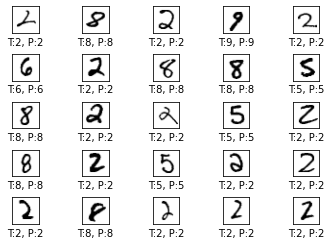

Incorrect Output Examples


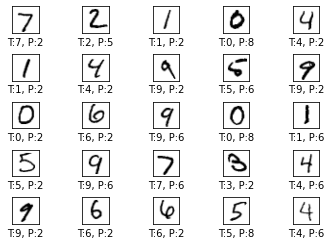

iteration 10000 - Accuracy on train-set: 92.1%, Accuracy on test-set: 92.1%
iteration 20000 - Accuracy on train-set: 92.5%, Accuracy on test-set: 92.5%
iteration 30000 - Accuracy on train-set: 93.1%, Accuracy on test-set: 93.1%
iteration 40000 - Accuracy on train-set: 94.0%, Accuracy on test-set: 94.0%
iteration 50000 - Accuracy on train-set: 94.4%, Accuracy on test-set: 94.4%
Correct Output Examples


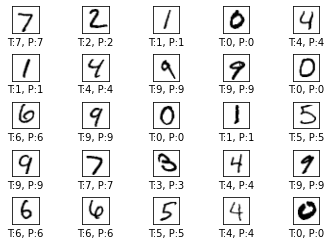

Incorrect Output Examples


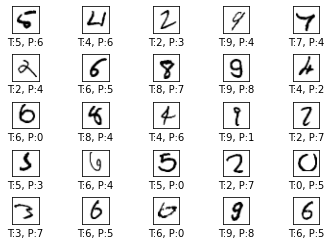

iteration 60000 - Accuracy on train-set: 94.9%, Accuracy on test-set: 94.9%
iteration 70000 - Accuracy on train-set: 95.2%, Accuracy on test-set: 95.2%
iteration 80000 - Accuracy on train-set: 95.3%, Accuracy on test-set: 95.3%
iteration 90000 - Accuracy on train-set: 95.5%, Accuracy on test-set: 95.5%
iteration 100000 - Accuracy on train-set: 95.7%, Accuracy on test-set: 95.7%
Correct Output Examples


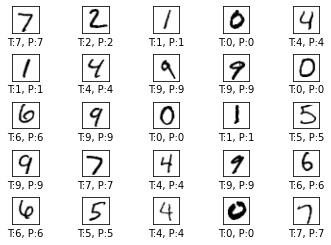

Incorrect Output Examples


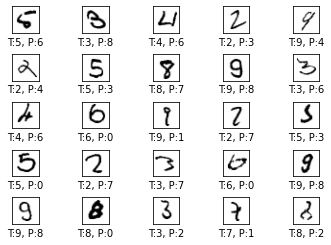

iteration 110000 - Accuracy on train-set: 95.9%, Accuracy on test-set: 95.9%
iteration 120000 - Accuracy on train-set: 95.8%, Accuracy on test-set: 95.8%
iteration 130000 - Accuracy on train-set: 95.8%, Accuracy on test-set: 95.8%
iteration 140000 - Accuracy on train-set: 96.0%, Accuracy on test-set: 96.0%
iteration 150000 - Accuracy on train-set: 96.0%, Accuracy on test-set: 96.0%
Correct Output Examples


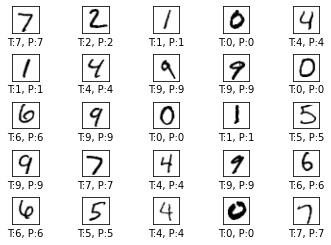

Incorrect Output Examples


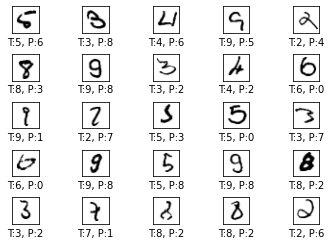

iteration 160000 - Accuracy on train-set: 96.0%, Accuracy on test-set: 96.0%
iteration 170000 - Accuracy on train-set: 96.0%, Accuracy on test-set: 96.0%
iteration 180000 - Accuracy on train-set: 96.2%, Accuracy on test-set: 96.2%
iteration 190000 - Accuracy on train-set: 96.2%, Accuracy on test-set: 96.2%
iteration 200000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
Correct Output Examples


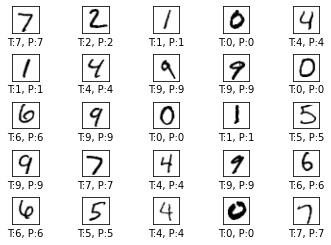

Incorrect Output Examples


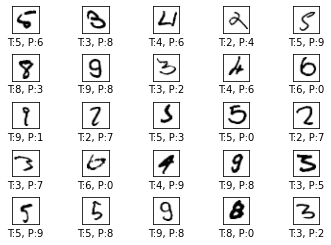

iteration 210000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
iteration 220000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
iteration 230000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
iteration 240000 - Accuracy on train-set: 96.4%, Accuracy on test-set: 96.4%
iteration 250000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
Correct Output Examples


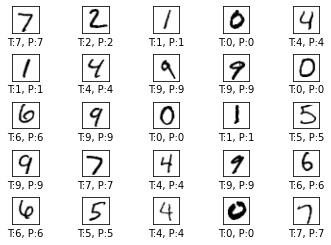

Incorrect Output Examples


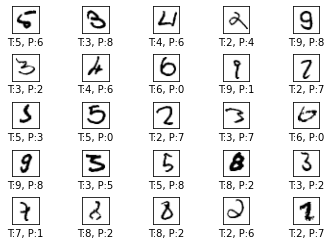

iteration 260000 - Accuracy on train-set: 96.2%, Accuracy on test-set: 96.2%
iteration 270000 - Accuracy on train-set: 96.4%, Accuracy on test-set: 96.4%
iteration 280000 - Accuracy on train-set: 96.3%, Accuracy on test-set: 96.3%
iteration 290000 - Accuracy on train-set: 96.2%, Accuracy on test-set: 96.2%
iteration 300000 - Accuracy on train-set: 96.2%, Accuracy on test-set: 96.2%
Correct Output Examples


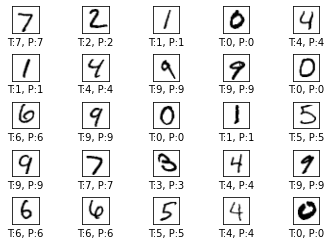

Incorrect Output Examples


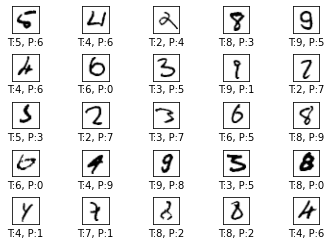

In [18]:
optimize(iterations)